In [6]:
import abc
from typing import List, Optional, Tuple

import cv2
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
from diffusers import StableDiffusionPipeline

In [2]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda:0")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
LOW_RESOURCE = False
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5

In [4]:
class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        

def register_attention_control(model, controller):
    def ca_forward(self, place_in_unet):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = self.to_out[0]
        else:
            to_out = self.to_out

        def forward(x, encoder_hidden_states=None,  attention_mask=None):
            batch_size, sequence_length, dim = x.shape
            h = self.heads
            q = self.to_q(x)
            is_cross = encoder_hidden_states is not None
            context = encoder_hidden_states if is_cross else x
            k = self.to_k(context)
            v = self.to_v(context)
            q = self.head_to_batch_dim(q)
            k = self.head_to_batch_dim(k)
            v = self.head_to_batch_dim(v)

            sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

            if attention_mask is not None:
                attention_mask = attention_mask.reshape(batch_size, -1)
                max_neg_value = -torch.finfo(sim.dtype).max
                attention_mask = attention_mask[:, None, :].repeat(h, 1, 1)
                sim.masked_fill_(~attention_mask, max_neg_value)

            # attention, what we cannot get enough of
            attn = sim.softmax(dim=-1)
#             print("new forward clas")
            attn = controller(attn, is_cross, place_in_unet)
            out = torch.einsum("b i j, b j d -> b i d", attn, v)
            out = self.batch_to_head_dim(out)
            return to_out(out)

        return forward

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if hasattr(net_, 'to_k') and net_.to_k.weight.shape[1]==768:
#             print("new attention clas")
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    sub_nets = model.unet.named_children()
    for net in sub_nets:
        if "down" in net[0]:
            print("register", net[0])
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            cross_att_count += register_recr(net[1], 0, "mid")

    controller.num_att_layers = cross_att_count


In [20]:
def init_latent(latent, model, height, width, generator, batch_size):
    if latent is None:
        latent = torch.randn(
            (1, model.unet.in_channels, height // 8, width // 8),
            generator=generator,
        )
    latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)
    return latent, latents


def diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False):
    if low_resource:
        noise_pred_uncond = model.unet(latents, t, encoder_hidden_states=context[0])["sample"]
        noise_prediction_text = model.unet(latents, t, encoder_hidden_states=context[1])["sample"]
    else:
        latents_input = torch.cat([latents] * 2)
        noise_pred = model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
    latents = controller.step_callback(latents)
    return latents


def latent2image(vae, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents)['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image


@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    register_attention_control(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = init_latent(latent, model, height, width, generator, batch_size)
    latent = latent.to(dtype=text_embeddings.dtype)
    latents = latents.to(dtype=text_embeddings.dtype)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent



def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)


def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img


def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        print(attention_maps.keys())
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(prompt: str, tokenizer, attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompt)
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    view_images(np.stack(images, axis=0))
    

In [21]:
def evaluate(prompt: str):
    prompts = [prompt]
    controller = AttentionStore()
    images, x_t = text2image_ldm_stable(
        pipe, prompts, controller,
        latent=None, num_inference_steps=NUM_DDIM_STEPS, 
        guidance_scale=GUIDANCE_SCALE, generator=None, 
        uncond_embeddings=None
    )
    view_images(images)
    show_cross_attention(prompt, pipe.tokenizer, controller, 16, ["up", "down"])

/tmp/ipykernel_1929848/593646253.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/593646253.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.97it/s]


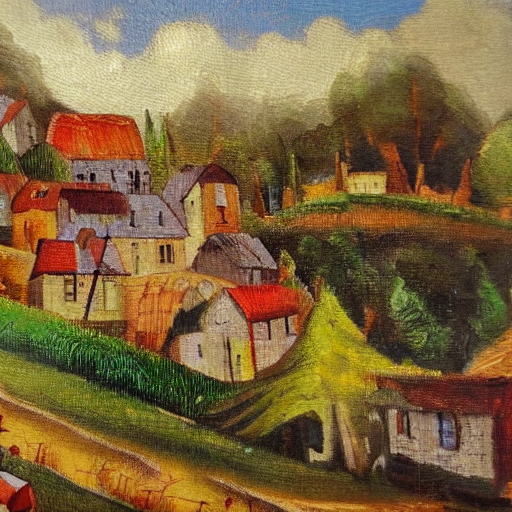

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


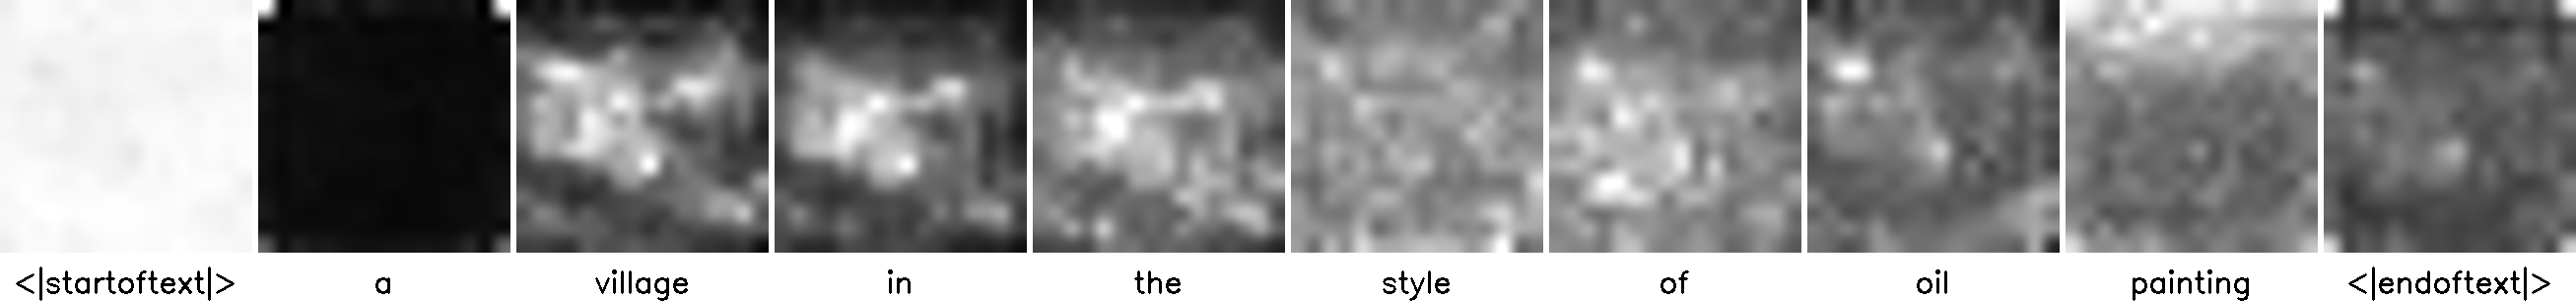

In [16]:
evaluate("a village in the style of oil painting")

/tmp/ipykernel_1929848/593646253.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/593646253.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.96it/s]


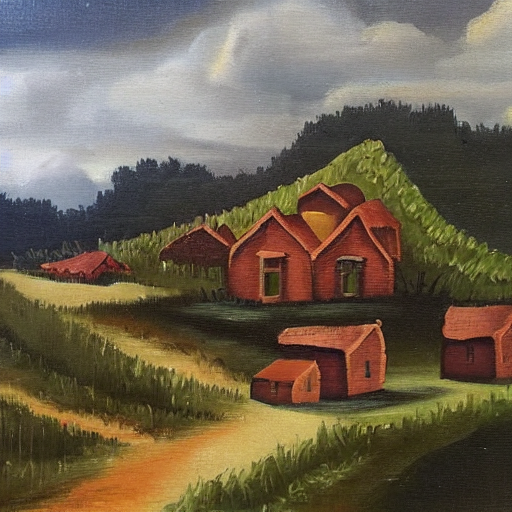

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


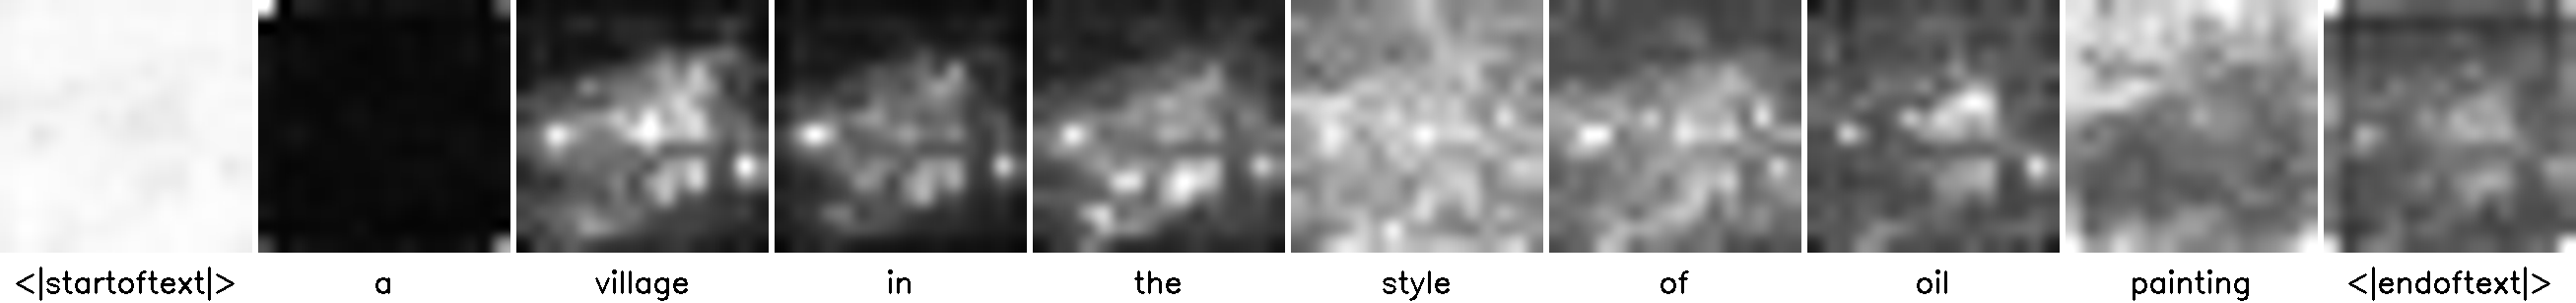

In [17]:
evaluate("a village in the style of oil painting")

/tmp/ipykernel_1929848/331612656.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/331612656.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.88it/s]


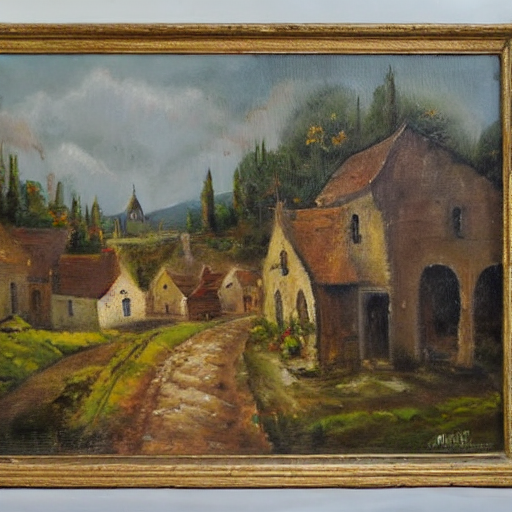

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


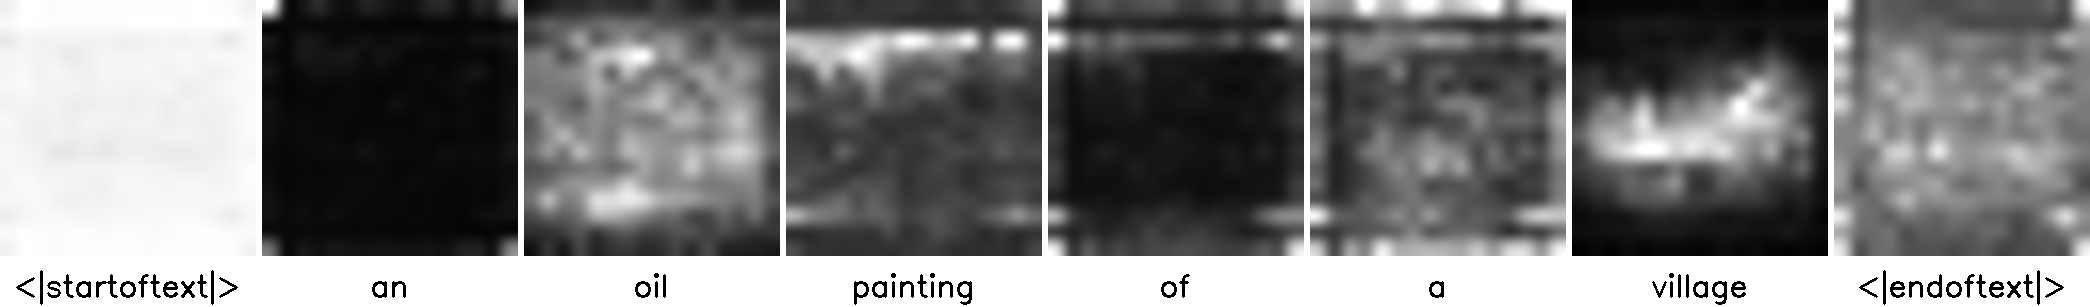

In [22]:
evaluate("an oil painting of a village")

/tmp/ipykernel_1929848/331612656.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/331612656.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.94it/s]


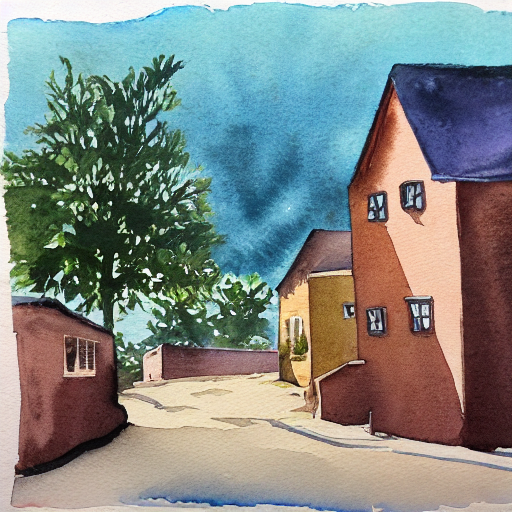

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


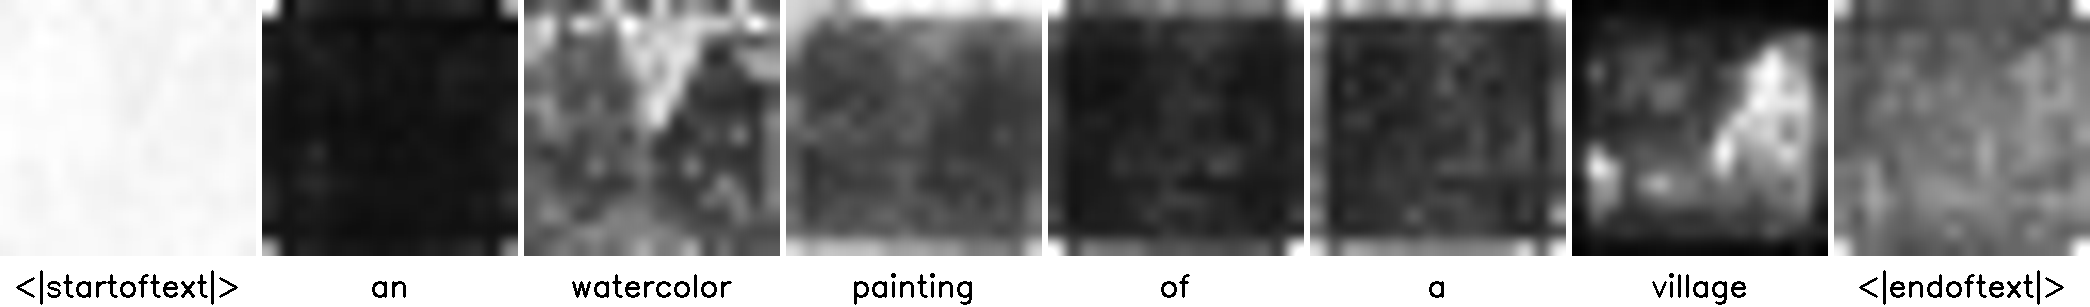

In [23]:
evaluate("an watercolor painting of a village")

/tmp/ipykernel_1929848/331612656.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/331612656.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.89it/s]


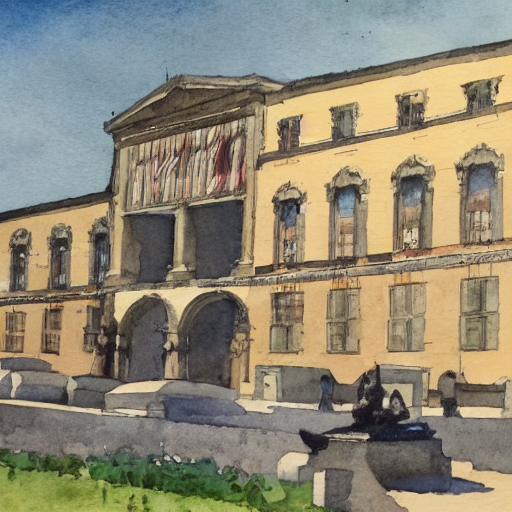

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


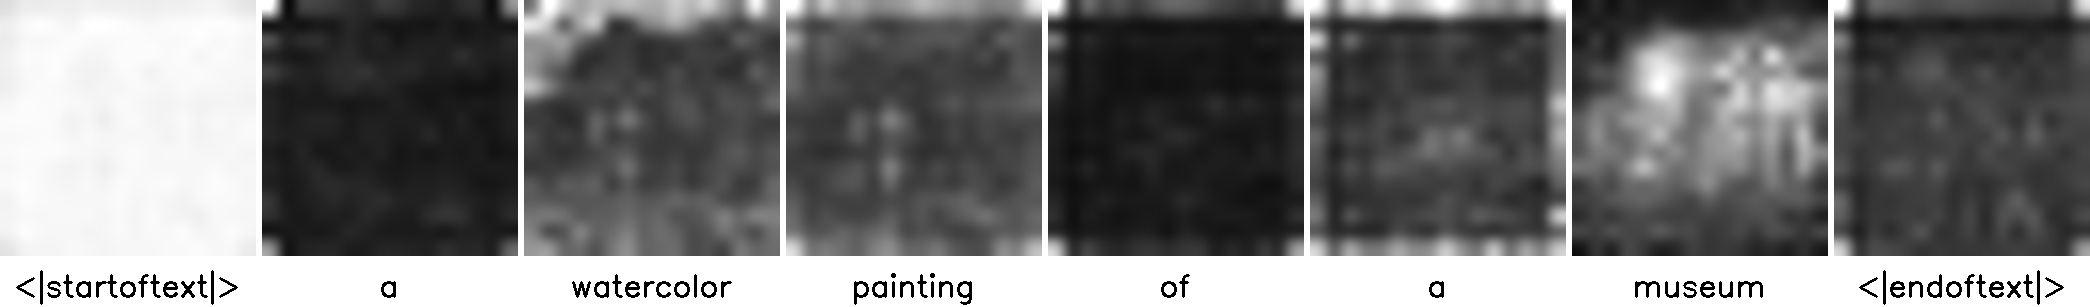

In [25]:
evaluate("a watercolor painting of a museum")

/tmp/ipykernel_1929848/331612656.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/331612656.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.81it/s]


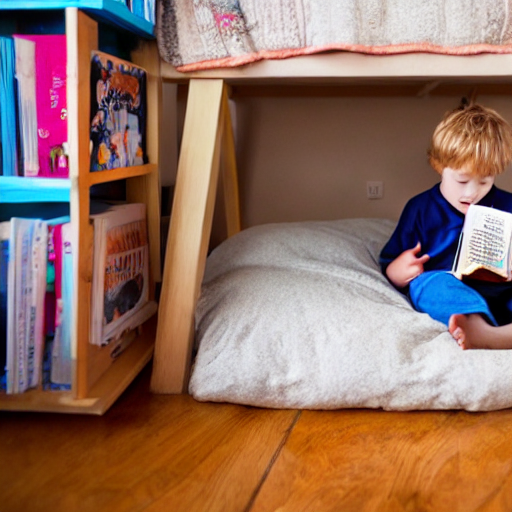

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


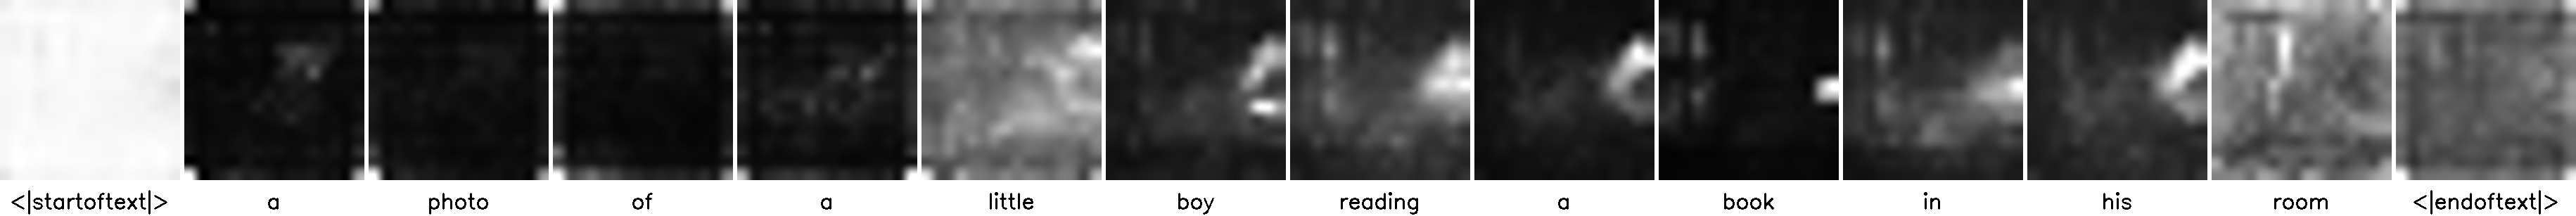

In [26]:
evaluate("a photo of a little boy reading a book in his room")

/tmp/ipykernel_1929848/331612656.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_1929848/331612656.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


register down_blocks


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.83it/s]


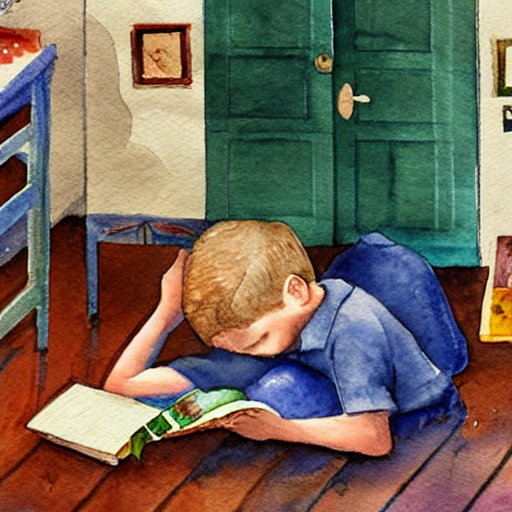

dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])


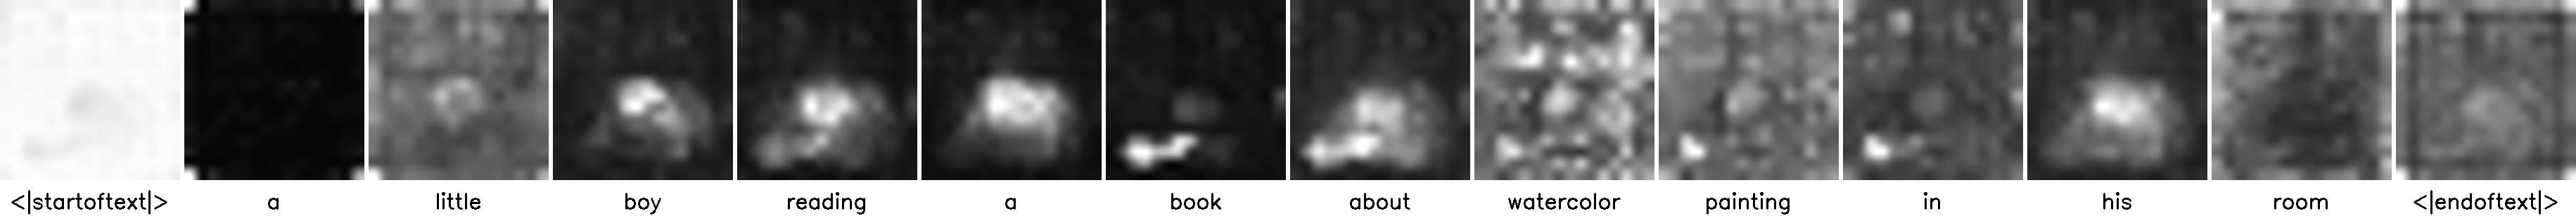

In [31]:
evaluate("a little boy reading a book about watercolor painting in his room")